In [2]:
import numpy as np
import cupy as cp
import skimage.io
import skimage.color
import matplotlib.pyplot as plt
from skimage.transform import downscale_local_mean
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from numba import njit
import time


In [3]:
@njit
def mirror_cpu(A, f):
    n, m = A.shape
    nlin = n + 2*f
    ncol = m + 2*f
    B = np.zeros((nlin, ncol), dtype=A.dtype)

    B[f:n+f, f:m+f] = A
    B[0:f, f:m+f] = A[0:f, :][::-1, :]
    B[n+f:, f:m+f] = A[n-f:, :][::-1, :]
    B[f:n+f, 0:f] = A[:, 0:f][:, ::-1]
    B[f:n+f, m+f:] = A[:, m-f:][:, ::-1]
    B[0:f, 0:f] = A[0:f, 0:f][::-1, ::-1]
    B[0:f, m+f:] = A[0:f, m-f:][::-1, ::-1]
    B[n+f:, 0:f] = A[n-f:, 0:f][::-1, ::-1]
    B[n+f:, m+f:] = A[n-f:, m-f:][::-1, ::-1]

    return B


In [4]:
@njit
def NLM_fast_cpu(img, h, f, t):
    m, n = img.shape
    filtrada = np.zeros((m, n), dtype=img.dtype)
    img_n = mirror_cpu(img, f)
    for i in range(m):
        for j in range(n):
            im = i + f
            jn = j + f
            W1 = img_n[im-f:im+f+1, jn-f:jn+f+1]
            rmin = max(im-t, f)
            rmax = min(im+t, m+f-1)
            smin = max(jn-t, f)
            smax = min(jn+t, n+f-1)
            NL = 0.0
            Z = 0.0
            for r in range(rmin, rmax+1):
                for s in range(smin, smax+1):
                    W2 = img_n[r-f:r+f+1, s-f:s+f+1]
                    d2 = np.sum((W1 - W2)**2)
                    sij = np.exp(-d2/(h**2))
                    Z += sij
                    NL += sij * img_n[r, s]
            filtrada[i, j] = NL / Z
    return filtrada


In [5]:
def mirror_gpu(A, f):
    n, m = A.shape
    B = cp.zeros((n + 2*f, m + 2*f), dtype=A.dtype)
    B[f:n+f, f:m+f] = A
    B[0:f, f:m+f] = A[0:f, :][::-1, :]
    B[n+f:, f:m+f] = A[n-f:, :][::-1, :]
    B[f:n+f, 0:f] = A[:, 0:f][:, ::-1]
    B[f:n+f, m+f:] = A[:, m-f:][:, ::-1]
    B[0:f, 0:f] = A[0:f, 0:f][::-1, ::-1]
    B[0:f, m+f:] = A[0:f, m-f:][::-1, ::-1]
    B[n+f:, 0:f] = A[n-f:, 0:f][::-1, ::-1]
    B[n+f:, m+f:] = A[n-f:, m-f:][::-1, ::-1]
    return B


In [6]:
nlm_kernel_global_code = r'''
extern "C" __global__
void nlm_kernel_global(
    const float* img_n, float* output,
    int m, int n, int f, int t, float h, int padded_width
) {
    int i = blockIdx.y * blockDim.y + threadIdx.y;
    int j = blockIdx.x * blockDim.x + threadIdx.x;

    if (i >= m || j >= n)
        return;

    int im = i + f;
    int jm = j + f;

    float NL = 0.0f;
    float Z = 0.0f;

    for (int r = im - t; r <= im + t; ++r) {
        for (int s = jm - t; s <= jm + t; ++s) {
            float d2 = 0.0f;
            for (int u = -f; u <= f; ++u) {
                for (int v = -f; v <= f; ++v) {
                    int x1 = im + u;
                    int y1 = jm + v;
                    int x2 = r + u;
                    int y2 = s + v;

                    float val1 = img_n[x1 * padded_width + y1];
                    float val2 = img_n[x2 * padded_width + y2];
                    float diff = val1 - val2;
                    d2 += diff * diff;
                }
            }
            float weight = __expf(-d2 / (h * h));
            Z += weight;
            NL += weight * img_n[r * padded_width + s];
        }
    }

    output[i * n + j] = NL / Z;
}
'''



In [7]:
import sklearn.neighbors as sknn
import networkx as nx

def process_pixel(i, j, img_n, f, t, h, nn, m, n):
    im = i + f
    jn = j + f
    patch_central = img_n[im - f:im + f + 1, jn - f:jn + f + 1]
    central = patch_central.ravel()

    rmin = max(im - t, f)
    rmax = min(im + t, m + f)
    smin = max(jn - t, f)
    smax = min(jn + t, n + f)

    n_patches = (rmax - rmin) * (smax - smin)
    patch_size = (2 * f + 1) ** 2

    dataset = np.empty((n_patches, patch_size), dtype=np.float32)
    pixels_busca = np.empty(n_patches, dtype=np.float32)

    source = -1
    k = 0
    for r in range(rmin, rmax):
        for s in range(smin, smax):
            W = img_n[r - f:r + f + 1, s - f:s + f + 1]
            neighbor = W.ravel()
            dataset[k, :] = neighbor
            pixels_busca[k] = img_n[r, s]
            if np.array_equal(central, neighbor):
                source = k
            k += 1

    if source == -1:
        source = 0  # fallback para evitar erro

    knnGraph = sknn.kneighbors_graph(dataset, n_neighbors=nn, mode='distance')
    G = nx.from_scipy_sparse_array(knnGraph)
    length, _ = nx.single_source_dijkstra(G, source)

    points = list(length.keys())
    distancias = np.array(list(length.values()), dtype=np.float32)

    similaridades = np.exp(-distancias ** 2 / (h ** 2))
    pixels = pixels_busca[points]

    NL = np.sum(similaridades * pixels)
    Z = np.sum(similaridades)
    return NL / Z if Z > 0 else img_n[im, jn]


from joblib import Parallel, delayed

def Parallel_GEONLM(img_n, f, t, h, nn):
    print(f'img_n.shape: {img_n.shape}')
    m = img_n.shape[0] - 2 * f
    n = img_n.shape[1] - 2 * f
    print(f'M: {m}, N: {n}')

    filtrada = Parallel(n_jobs=-1)(
        delayed(process_pixel)(i, j, img_n, f, t, h, nn, m, n)
        for i in range(m)
        for j in range(n)
    )

    filtrada_geo = np.array(filtrada).reshape((m, n))
    return filtrada_geo

In [8]:
def NLM_fast_cuda_global(img, h, f, t):
    img = img.astype(cp.float32)
    m, n = img.shape
    padded = mirror_gpu(img, f)

    module = cp.RawModule(code=nlm_kernel_global_code, options=('-std=c++11',))
    kernel = module.get_function("nlm_kernel_global")

    output = cp.zeros((m, n), dtype=cp.float32)
    threads_per_block = (16, 16)
    grid = ((n + 15) // 16, (m + 15) // 16)

    kernel(
        grid, threads_per_block,
        (
            padded.ravel(), output.ravel(),
            cp.int32(m), cp.int32(n), cp.int32(f), cp.int32(t),
            cp.float32(h), cp.int32(padded.shape[1])
        )
    )
    return output

def add_noise_gaussian(img):
    m, n = img.shape
    sigma = 10
    noise = np.random.normal(0, sigma, (m, n)).astype(np.float32)
    noised = np.clip(img + noise, 0, 255)
    return noised

def add_poisson_noise(img):    
    poisson_img = np.random.poisson(img)    
    return poisson_img

def add_poisson_gaussian_noise(image, gaussian_sigma=25):
    # Apply Poisson noise
    poisson_image = np.random.poisson(image)

    # Apply Gaussian noise
    gaussian_noise = np.random.normal(loc=0.0, scale=gaussian_sigma, size=image.shape)
    noisy_image = poisson_image + gaussian_noise 

    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image

def downscale(img):
    img_downscale = downscale_local_mean(img, (2, 2)).astype(np.float32)
    return img_downscale

def anscombe_transform(img):
    return 2.0 * np.sqrt(img.astype(np.float32) + 3.0 / 8.0)

def inverse_anscombe(y):
    # Inversa exata de Makitalo & Foi (IEEE T-IP 2011)
    return ((y / 2.0)**2) - 3.0 / 8.0

def compute_adaptive_q(sigma_est, anscombe=False):
    q_nlm = 0.8 + 0.5 * np.tanh(0.3 * (sigma_est - 1))
    q_geo = 1.0 + 0.7 * np.tanh(0.25 * (sigma_est - 1.5))

    if anscombe:
        q_nlm = int(np.clip(q_nlm, 0.7, 2.2) * 10)
        q_geo = int(np.clip(q_geo, 0.9, 2.7) * 10)
    else:
        q_nlm = int(np.clip(q_nlm, 0.7, 2.2) * 100)
        q_geo = int(np.clip(q_geo, 0.9, 2.7) * 100)

    print(f'q_nlm: {q_nlm}, g_geo: {q_geo}')
    return q_nlm, q_geo

from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def select_best_h_using_adaptive_q(image, image_gpu, q_nlm_candidates, f, t, alpha=0.5, anscombe=False):
    melhor_score = -float('inf')
    melhor_q_nlm = None
    melhor_resultado = None
    melhor_psnr = None
    melhor_ssim = None

    for h_nlm in q_nlm_candidates:
        #print(f'h_nlm: {h_nlm}')

        # Aplica NLM
        result_gpu = NLM_fast_cuda_global(image_gpu, h_nlm, f, t)
        cp.cuda.Stream.null.synchronize()

        # Referência: imagem original
        img_ref = np.clip(image, 0, 255).astype(np.uint8)

        if anscombe:
            # Inversa de Anscombe
            result_processed = np.maximum(inverse_anscombe(cp.asnumpy(result_gpu)), 0)
        else:
            result_processed = cp.asnumpy(result_gpu)

        result_uint8 = np.clip(result_processed, 0, 255).astype(np.uint8)

        # Métricas
        psnr = peak_signal_noise_ratio(img_ref, result_uint8, data_range=255)
        ssim = structural_similarity(img_ref, result_uint8, data_range=255)

        # Score combinado
        score = alpha * psnr + (1 - alpha) * (ssim * 100)
        print(f"h = {h_nlm:.2f} | PSNR = {psnr:.2f} | SSIM = {ssim:.4f} | Score = {score:.2f}")

        if score > melhor_score:
            melhor_score = score
            melhor_q_nlm = h_nlm
            melhor_resultado = result_processed
            melhor_psnr = psnr
            melhor_ssim = ssim

    print(f"\n[SELECIONADO] H = {melhor_q_nlm:.2f} | PSNR = {melhor_psnr:.2f} | SSIM = {melhor_ssim:.4f} | SCORE = {melhor_score:.2f}")

    return melhor_resultado, melhor_q_nlm, melhor_psnr, melhor_ssim, melhor_score


In [9]:
import os
def read_directories(directory, img=None, exclude_json=None):
    # Get a list of filenames in the specified directory
    filenames = []
    for filename in os.listdir(directory):
        if img is not None:
            # If 'img' is provided, filter filenames containing it
            if img in filename:   
                filenames.append(filename)
        elif exclude_json is not None:
            filenames.append(filename.replace('.json',''))     
        else:
            filenames.append(filename)    
    return filenames

### Noise Gaussian

In [39]:
from skimage.restoration import estimate_sigma
import sys


from pathlib import Path


dir_images = ("/workspace/ProjetoDoutorado/wvc/images")



#dir_out_nlm = f'{root_dir}/wvc/best_out_put_Gaussian_NLM'
#dir_out_geonlm = f'{root_dir}/wvc/best_out_put_Gaussian_GEONLM'


array_dir = read_directories(dir_images)

array_nln_filtereds = []

for file in array_dir:

    file_name = file
    img = skimage.io.imread(f'{dir_images}/{file_name}')
    img = img[0, :, :] if len(img.shape) > 2 else img
    if len(img.shape) > 2:
        img = skimage.color.rgb2gray(img)
        img = 255 * img


    m, n = img.shape
    sigma = 10
    ruido = np.random.normal(0, sigma, (m, n)).astype(np.float32)
    ruidosa = np.clip(img + ruido, 0, 255)

    # Preparo para CPU e GPU
    img_noisse_gaussian_np = ruidosa.astype(np.float32)
    estimated_sigma_gaussian_np = estimate_sigma(img_noisse_gaussian_np)
    img_gpu_noisse_gaussian = cp.array(img_noisse_gaussian_np)


    h_nlm , g_nlm = compute_adaptive_q(estimated_sigma_gaussian_np)

    q_nlm_candidates = np.array([h_nlm + delta for delta in range(-50, 25, 1)])


    img_filtered_nlm, nlm_h, nlm_psnr, nlm_ssim, nlm_score = select_best_h_using_adaptive_q(
        image=img,
        image_gpu=img_gpu_noisse_gaussian,
        q_nlm_candidates=q_nlm_candidates,
        f=4, t=7,
        alpha=0.5,
        anscombe=False
    )

    dict = {
        'img_filtered_nlm': img_filtered_nlm,
        'img_noisse_gaussian_np':img_noisse_gaussian_np,
        'img_gpu_noisse_gaussian':img_gpu_noisse_gaussian,
        'nlm_h':nlm_h, 
        'nlm_psnr': nlm_psnr,
        'nlm_ssim':nlm_ssim,
        'nlm_score':nlm_score,
        'file_name':file_name,
    }
    array_nln_filtereds.append(dict)

q_nlm: 129, g_geo: 169
h = 79.00 | PSNR = 29.95 | SSIM = 0.8859 | Score = 59.27
h = 80.00 | PSNR = 30.01 | SSIM = 0.8866 | Score = 59.34
h = 81.00 | PSNR = 30.07 | SSIM = 0.8872 | Score = 59.40
h = 82.00 | PSNR = 30.12 | SSIM = 0.8876 | Score = 59.44
h = 83.00 | PSNR = 30.18 | SSIM = 0.8879 | Score = 59.48
h = 84.00 | PSNR = 30.23 | SSIM = 0.8880 | Score = 59.51
h = 85.00 | PSNR = 30.27 | SSIM = 0.8881 | Score = 59.54
h = 86.00 | PSNR = 30.32 | SSIM = 0.8879 | Score = 59.56
h = 87.00 | PSNR = 30.36 | SSIM = 0.8877 | Score = 59.57
h = 88.00 | PSNR = 30.40 | SSIM = 0.8874 | Score = 59.57
h = 89.00 | PSNR = 30.44 | SSIM = 0.8869 | Score = 59.56
h = 90.00 | PSNR = 30.47 | SSIM = 0.8863 | Score = 59.55
h = 91.00 | PSNR = 30.50 | SSIM = 0.8856 | Score = 59.53
h = 92.00 | PSNR = 30.53 | SSIM = 0.8848 | Score = 59.50
h = 93.00 | PSNR = 30.55 | SSIM = 0.8839 | Score = 59.47
h = 94.00 | PSNR = 30.57 | SSIM = 0.8829 | Score = 59.43
h = 95.00 | PSNR = 30.59 | SSIM = 0.8818 | Score = 59.38
h = 96.0

In [10]:
import pickle
from pathlib import Path

def save_pickle(obj, path):
    path = Path(path)
    with path.open("wb") as f:
        # usa o protocolo mais moderno disponível
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_pickle(path):
    path = Path(path)
    with path.open("rb") as f:
        return pickle.load(f)


In [42]:
save_pickle(array_nln_filtereds, "resultados.pkl")

In [43]:
vetor2 = load_pickle("resultados.pkl")

# Verifique:
import numpy as np
print(type(vetor2[0]["img_filtered_nlm"]), vetor2[0]["img_filtered_nlm"].shape, vetor2[0]["img_filtered_nlm"].dtype)

<class 'numpy.ndarray'> (512, 512) float32


In [44]:
#img_filtered_nlm ==> Imagem filtrada pelo Non Local Means Padrão
#img_noisse_gaussian_np

print(f'nlm_h: {nlm_h}')
print(f'nlm_psnr: {nlm_psnr}')
print(f'nlm_ssim: {nlm_ssim}')
print(f'nlm_score: {nlm_score}')


nlm_h: 86
nlm_psnr: 31.906413219724087
nlm_ssim: 0.8965981427164387
nlm_score: 60.78311374568398


### Paralel

### Novo 09/09/25

In [11]:
# def run_single_pipeline(img_base, f, t, nn):
#     img_noisy = add_noise_gaussian(img_base)
#     sigma = estimate_sigma(img_noisy)
#     h_nlm, _ = compute_adaptive_q(sigma)
#     img_noisy_mirror = mirror_cpu(img_noisy, f)

#     melhor_img, melhor_h, psnr, ssim, score= run_geonlm_pipeline(
#         img_original=img_base,
#         img_noisy=img_noisy_mirror,
#         f=f, t=t,
#         h_base=h_nlm,
#         nn=nn
#     )
#     return img_base, img_noisy, melhor_img, melhor_h, psnr, ssim, score


def run_geonlm_pipeline2(img_original, img_noisy, f, t, nn=10, h_multipliers=[0.85, 0.90,0.95,1, 1.05]):#, 1.10, 1.15, 1.2, 1.23, 1.25,1.35]):

    img_noisy_mirror = mirror_cpu(img_noisy, f)
    h_base, _ = compute_adaptive_q(sigma)

    # Versão com paralelismo (ficou mais rápida)
    img_n_geo = np.pad(img_noisy_mirror, ((f, f), (f, f)), 'symmetric')

    melhor_score = -np.inf
    melhor_img = None
    melhor_h = None
    melhor_psnr = None
    melhor_ssim = None

    for mult in h_multipliers:
        h_geo = (h_base)  * mult
        print(f"\nExecutando GEONLM com h = {h_geo:.2f} (base {h_base} * {mult})")

        img_geo = Parallel_GEONLM(img_n_geo, f=f, t=t, h=h_geo, nn=nn)

        img_geo_no_pad = img_geo[f:-f, f:-f]  # Remove 'f' pixels de cada lado
        img_geo_no_pad = np.clip(img_geo_no_pad, 0, 255).astype(np.uint8)

        img_ref = np.clip(img_original, 0, 255).astype(np.uint8)
        #img_geo_uint8 = np.clip(img_geo, 0, 255).astype(np.uint8)

        psnr = peak_signal_noise_ratio(img_ref, img_geo_no_pad, data_range=255)
        ssim = structural_similarity(img_ref, img_geo_no_pad, data_range=255)

        score = 0.5 * psnr + 0.5 * (ssim * 100)
        print(f"→ PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, Score: {score:.2f}")

        if score > melhor_score:
            melhor_score = score
            melhor_img = img_geo
            melhor_h = h_geo
            melhor_psnr = psnr
            melhor_ssim = ssim

    print(f"\n[FINAL] Melhor h: {melhor_h}, PSNR: {melhor_psnr:.2f}, SSIM: {melhor_ssim:.4f}, SCORE: {melhor_score:.4f} ")
    return melhor_img, melhor_h, melhor_psnr, melhor_ssim, melhor_score

def downscale_to_64(img):
    factor_h = img.shape[0] // 64
    factor_w = img.shape[1] // 64
    return downscale_local_mean(img, (factor_h, factor_w)).astype(np.float32)

def crop_center(img, size=(64, 64)):
    h, w = img.shape
    ch, cw = size
    start_h = h // 2 - ch // 2
    start_w = w // 2 - cw // 2
    return img[start_h:start_h+ch, start_w:start_w+cw].astype(np.float32)

In [12]:
def run_geonlm_pipeline(img_original, h_base, img_noisy, f, t, mult, nn=10):

    img_noisy_mirror = mirror_cpu(img_noisy, f)    
   
    img_n_geo = np.pad(img_noisy_mirror, ((f, f), (f, f)), 'symmetric')  
   
   
    h_geo = (h_base) * mult
    print(f"\nExecutando GEONLM com h = {h_geo:.2f} (base {h_base} * {mult})")

    img_geo = Parallel_GEONLM(img_n_geo, f=f, t=t, h=h_geo, nn=nn)

    img_geo_no_pad = img_geo[f:-f, f:-f]  # Remove 'f' pixels de cada lado
    img_geo_no_pad = np.clip(img_geo_no_pad, 0, 255).astype(np.uint8)

    img_ref = np.clip(img_original, 0, 255).astype(np.uint8)   

    psnr = peak_signal_noise_ratio(img_ref, img_geo_no_pad, data_range=255)
    ssim = structural_similarity(img_ref, img_geo_no_pad, data_range=255)

    score = 0.5 * psnr + 0.5 * (ssim * 100)
    print(f"→ PSNR: {psnr:.2f}, SSIM: {ssim:.4f}, Score: {score:.2f}")    

   
    return img_geo_no_pad, h_geo, psnr, ssim, score

### Antes

In [ ]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10

# ------------------------- DOWNCALE PARA 64x64 -------------------------
# Redimensionando a imagem para 64x64
img_downscaled = downscale_to_64(img)
imagem_ruidosa_downscaled = downscale_to_64(img_noisse_gaussian_np)

# ------------------------- EXECUÇÃO DO PIPELINE -------------------------
# Chamando a função que executa o pipeline de filtragem
print("\n--- Executando Pipeline com Downscale 64x64 ---")
# Executar o pipeline com a imagem ruidosa
melhor_img, melhor_h, melhor_psnr, melhor_ssim, melhor_score = run_geonlm_pipeline2(img_downscaled, imagem_ruidosa_downscaled, f, t, nn)

# Exibir o resultado
print(f"Melhor valor de h: {melhor_h}")
print(f"PSNR: {melhor_psnr:.2f}, SSIM: {melhor_ssim:.4f}, Score: {melhor_score:.2f}")

img_downscaled_4 = downscale_local_mean(img, (4, 4)).astype(np.float32)
imagem_ruidosa_downscaled_4 = downscale_local_mean(img_noisse_gaussian_np, (4, 4)).astype(np.float32)

print("\n--- Executando Pipeline com Downscale 128x128 ---")
# Executar o pipeline com a imagem ruidosa
melhor_img, melhor_h, melhor_psnr, melhor_ssim, melhor_score = run_geonlm_pipeline2(img_downscaled_4, imagem_ruidosa_downscaled_4, f, t, nn)

# Exibir o resultado
print(f"Melhor valor de h: {melhor_h}")
print(f"PSNR: {melhor_psnr:.2f}, SSIM: {melhor_ssim:.4f}, Score: {melhor_score:.2f}")


img_downscaled_2 = downscale_local_mean(img, (2, 2)).astype(np.float32)
imagem_ruidosa_downscaled_2 = downscale_local_mean(img_noisse_gaussian_np, (2, 2)).astype(np.float32)

print("\n--- Executando Pipeline com Downscale 256x256 ---")
# Executar o pipeline com a imagem ruidosa
melhor_img, melhor_h, melhor_psnr, melhor_ssim, melhor_score = run_geonlm_pipeline2(img_downscaled_2, imagem_ruidosa_downscaled_2, f, t, nn)

# Exibir o resultado
print(f"Melhor valor de h: {melhor_h}")
print(f"PSNR: {melhor_psnr:.2f}, SSIM: {melhor_ssim:.4f}, Score: {melhor_score:.2f}")



print("\n--- Executando Pipeline com Downscale 512x512 ---")
# Executar o pipeline com a imagem ruidosa
melhor_img, melhor_h, melhor_psnr, melhor_ssim, melhor_score = run_geonlm_pipeline2(img, img_noisse_gaussian_np, f, t, nn)

# Exibir o resultado
print(f"Melhor valor de h: {melhor_h}")
print(f"PSNR: {melhor_psnr:.2f}, SSIM: {melhor_ssim:.4f}, Score: {melhor_score:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img_downscaled.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(imagem_ruidosa_downscaled.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(melhor_img.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()

### Novo


--- Executando Pipeline com Downscale 512x512 ---

Executando GEONLM com h = 119.60 (base 92 * 1.3)
img_n.shape: (520, 520)
M: 516, N: 516
→ PSNR: 34.54, SSIM: 0.8910, Score: 61.82

Executando GEONLM com h = 128.80 (base 92 * 1.4)
img_n.shape: (520, 520)
M: 516, N: 516
→ PSNR: 34.48, SSIM: 0.8918, Score: 61.83

[FINAL] Melhor h: 128.79999999999998, PSNR: 34.48, SSIM: 0.8918, SCORE: 61.8267 
Melhor valor de h: 135.45000000000002
PSNR: 34.48, SSIM: 0.8918, Score: 61.83


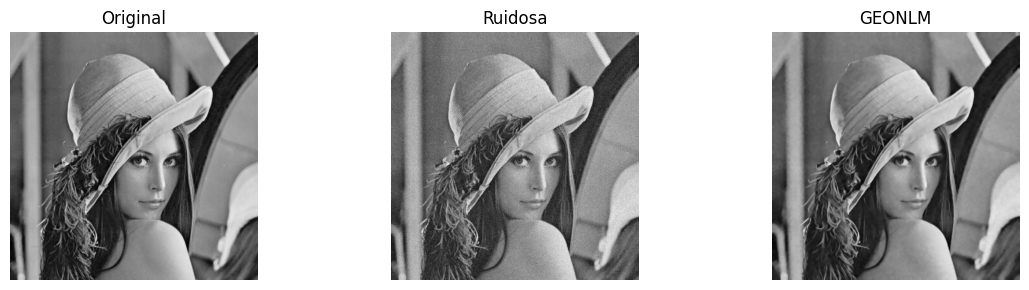

In [ ]:
# ------------------------- EXEMPLO DE USO COM 3 ABORDAGENS -------------------------

# Parâmetros
f = 4
t = 7
nn = 10


print("\n--- Executando Pipeline com Downscale 512x512 ---")
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm, h_gnlm, psnr_gnlm, ssim_gnlm, score_gnlm = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, nn)

# Exibir o resultado
print(f"Melhor valor de h: {melhor_h}")
print(f"PSNR: {psnr_gnlm:.2f}, SSIM: {ssim_gnlm:.4f}, Score: {score_gnlm:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()


--- Executando Pipeline com Downscale 512x512 ---

Executando GEONLM com h = 119.60 (base 92 * 1.3)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.45, SSIM: 0.8849, Score: 61.47

Executando GEONLM com h = 128.80 (base 92 * 1.4)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.74, SSIM: 0.8927, Score: 62.01

[FINAL] Melhor h: 128.79999999999998, PSNR: 34.74, SSIM: 0.8927, SCORE: 62.0079 
Melhor valor de h: 135.45000000000002
PSNR: 34.74, SSIM: 0.8927, Score: 62.01


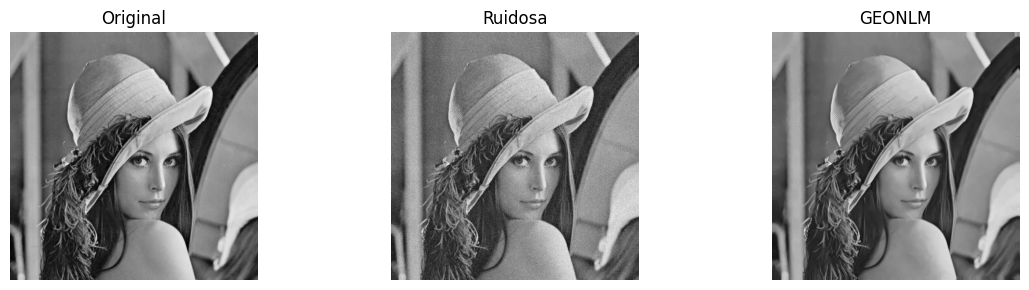

In [ ]:
# Parâmetros
f = 2
t = 4
nn = 5


print("\n--- Executando Pipeline com Downscale 512x512 ---")
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm, h_gnlm, psnr_gnlm, ssim_gnlm, score_gnlm = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, nn)

# Exibir o resultado
print(f"Melhor valor de h: {melhor_h}")
print(f"PSNR: {psnr_gnlm:.2f}, SSIM: {ssim_gnlm:.4f}, Score: {score_gnlm:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()


--- Executando Pipeline com Downscale 512x512 ---

Executando GEONLM com h = 128.80 (base 92 * 1.4)
img_n.shape: (520, 520)
M: 516, N: 516


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


→ PSNR: 34.45, SSIM: 0.8892, Score: 61.68
Melhor valor de h: 135.45000000000002
PSNR: 34.45, SSIM: 0.8892, Score: 61.68


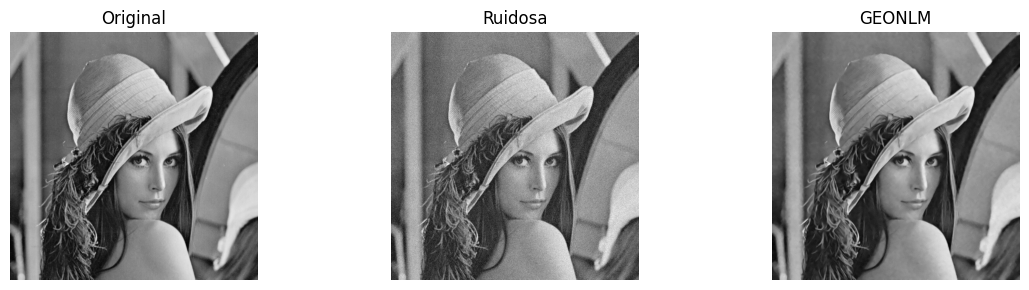

In [46]:
# Parâmetros
f = 2
t = 3
nn = 4


print("\n--- Executando Pipeline com Downscale 512x512 ---")
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm, h_gnlm, psnr_gnlm, ssim_gnlm, score_gnlm = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, nn)

# Exibir o resultado
print(f"Melhor valor de h: {melhor_h}")
print(f"PSNR: {psnr_gnlm:.2f}, SSIM: {ssim_gnlm:.4f}, Score: {score_gnlm:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()

In [13]:
vetor2 = load_pickle("resultados.pkl")

# Verifique:
import numpy as np
print(type(vetor2[0]["img_filtered_nlm"]), vetor2[0]["img_filtered_nlm"].shape, vetor2[0]["img_filtered_nlm"].dtype)

<class 'numpy.ndarray'> (512, 512) float32


In [15]:
alvo = "0.gif"
try:
    posicao = next(i for i, d in enumerate(vetor2) if d.get("file_name") == alvo)
    print(posicao)
except StopIteration:
    raise ValueError(f"file_name {alvo!r} não encontrado em vetor2")

7


In [ ]:
noissed = vetor2[7]['img_gpu_noisse_gaussian']
nlm_h = vetor2[7]['nlm_h']
file_name = vetor2[7]['file_name']


img = skimage.io.imread(f'{dir_images}/{file_name}')
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Parâmetros
f = 2
t = 3
nn = 4


print("\n--- Executando Pipeline com Downscale 512x512 ---")
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm, h_gnlm, psnr_gnlm, ssim_gnlm, score_gnlm = run_geonlm_pipeline(img, nlm_h, noissed, f, t, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm:.2f}, SSIM: {ssim_gnlm:.4f}, Score: {score_gnlm:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(noissed.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()


--- Executando Pipeline 512x512 com mult = 1.30 ---

Executando GEONLM com h = 107.90 (base 83 * 1.3)
img_n.shape: (528, 528)
M: 520, N: 520


/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


→ PSNR: 33.63, SSIM: 0.8434, Score: 58.99
PSNR: 33.63, SSIM: 0.8434, Score: 58.99

--- Executando Pipeline 512x512 com mult = 1.35 ---

Executando GEONLM com h = 112.05 (base 83 * 1.35)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 33.79, SSIM: 0.8478, Score: 59.29
PSNR: 33.63, SSIM: 0.8434, Score: 58.99

--- Executando Pipeline 512x512 com mult = 1.40 ---

Executando GEONLM com h = 116.20 (base 83 * 1.4)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 33.92, SSIM: 0.8511, Score: 59.51
PSNR: 33.915, SSIM: 0.8511, Score: 59.51

--- Executando Pipeline 512x512 com mult = 1.5 ---

Executando GEONLM com h = 124.50 (base 83 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.06, SSIM: 0.8553, Score: 59.79
PSNR: 34.062, SSIM: 0.8553, Score: 59.79


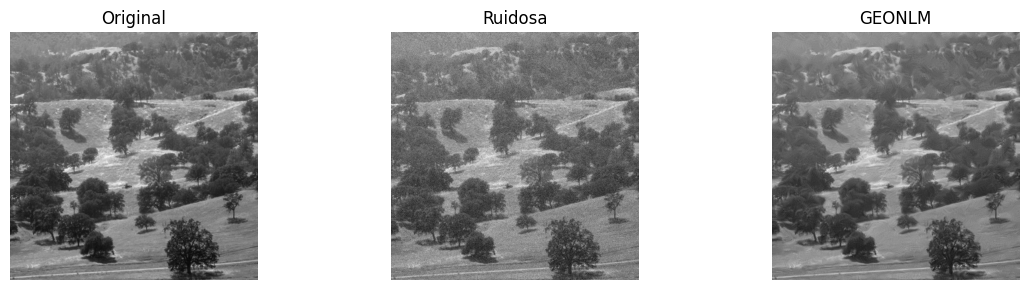

In [53]:
img_noisse_gaussian_np = array_nln_filtereds[6]['img_noisse_gaussian_np']

nlm_h = array_nln_filtereds[6]['nlm_h']
file_name = array_nln_filtereds[6]['file_name']

dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


img = skimage.io.imread(f'{dir_images}/{file_name}')
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Parâmetros
f = 4
t = 7
nn = 10
mult = 1.30

print("\n--- Executando Pipeline 512x512 com mult = 1.30 ---")
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm, h_gnlm, psnr_gnlm, ssim_gnlm, score_gnlm = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm:.2f}, SSIM: {ssim_gnlm:.4f}, Score: {score_gnlm:.2f}")

mult = 1.35
print("\n--- Executando Pipeline 512x512 com mult = 1.35 ---")
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm2, h_gnlm2, psnr_gnlm2, ssim_gnlm2, score_gnlm2 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm:.2f}, SSIM: {ssim_gnlm:.4f}, Score: {score_gnlm:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.40 ---")
mult = 1.40
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.5 ---")
mult = 1.50
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()


--- Executando Pipeline 512x512 com mult = 1.30 ---

Executando GEONLM com h = 117.00 (base 90 * 1.3)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 30.80, SSIM: 0.8951, Score: 60.16
PSNR: 30.80, SSIM: 0.8951, Score: 60.16

--- Executando Pipeline 512x512 com mult = 1.35 ---

Executando GEONLM com h = 121.50 (base 90 * 1.35)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 30.89, SSIM: 0.8955, Score: 60.22
PSNR: 30.80, SSIM: 0.8951, Score: 60.16

--- Executando Pipeline 512x512 com mult = 1.40 ---

Executando GEONLM com h = 126.00 (base 90 * 1.4)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 30.96, SSIM: 0.8952, Score: 60.24
PSNR: 30.958, SSIM: 0.8952, Score: 60.24

--- Executando Pipeline 512x512 com mult = 1.5 ---

Executando GEONLM com h = 135.00 (base 90 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 31.03, SSIM: 0.8936, Score: 60.19
PSNR: 31.030, SSIM: 0.8936, Score: 60.19


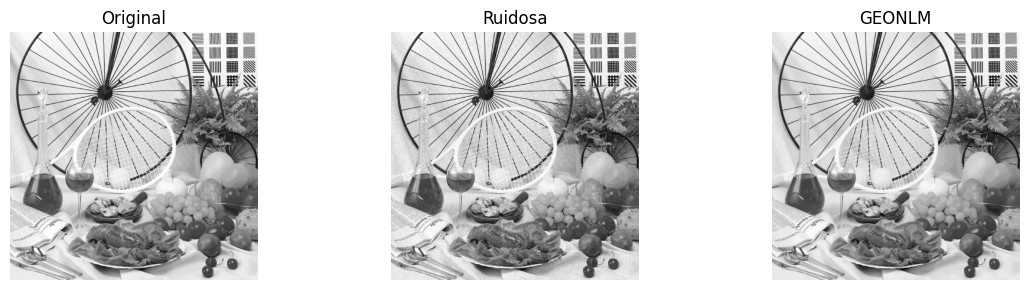

In [54]:
img_noisse_gaussian_np = array_nln_filtereds[5]['img_noisse_gaussian_np']

nlm_h = array_nln_filtereds[5]['nlm_h']
file_name = array_nln_filtereds[5]['file_name']

dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


img = skimage.io.imread(f'{dir_images}/{file_name}')
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Parâmetros
f = 4
t = 7
nn = 10
mult = 1.30

print("\n--- Executando Pipeline 512x512 com mult = 1.30 ---")
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm, h_gnlm, psnr_gnlm, ssim_gnlm, score_gnlm = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm:.2f}, SSIM: {ssim_gnlm:.4f}, Score: {score_gnlm:.2f}")

mult = 1.35
print("\n--- Executando Pipeline 512x512 com mult = 1.35 ---")
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm2, h_gnlm2, psnr_gnlm2, ssim_gnlm2, score_gnlm2 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm:.2f}, SSIM: {ssim_gnlm:.4f}, Score: {score_gnlm:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.40 ---")
mult = 1.40
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.5 ---")
mult = 1.50
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()


--- Executando Pipeline 512x512 com mult = 1.30 ---

Executando GEONLM com h = 120.90 (base 93 * 1.3)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.48, SSIM: 0.8848, Score: 61.48
PSNR: 34.48, SSIM: 0.8848, Score: 61.48

--- Executando Pipeline 512x512 com mult = 1.35 ---

Executando GEONLM com h = 125.55 (base 93 * 1.35)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.63, SSIM: 0.8891, Score: 61.77
PSNR: 34.48, SSIM: 0.8848, Score: 61.48

--- Executando Pipeline 512x512 com mult = 1.40 ---

Executando GEONLM com h = 130.20 (base 93 * 1.4)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.75, SSIM: 0.8925, Score: 62.00
PSNR: 34.752, SSIM: 0.8925, Score: 62.00

--- Executando Pipeline 512x512 com mult = 1.5 ---

Executando GEONLM com h = 139.50 (base 93 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.89, SSIM: 0.8969, Score: 62.29
PSNR: 34.889, SSIM: 0.8969, Score: 62.29


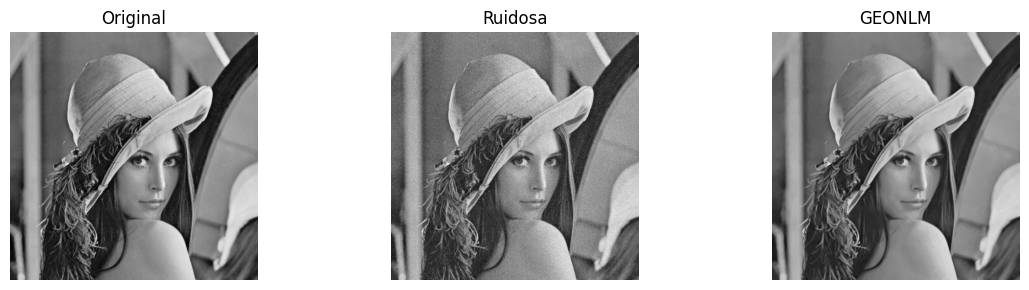

In [52]:

img_noisse_gaussian_np = array_nln_filtereds[7]['img_noisse_gaussian_np']

nlm_h = array_nln_filtereds[7]['nlm_h']
file_name = array_nln_filtereds[7]['file_name']

dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


img = skimage.io.imread(f'{dir_images}/{file_name}')
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Parâmetros
f = 4
t = 7
nn = 10
mult = 1.30

print("\n--- Executando Pipeline 512x512 com mult = 1.30 ---")
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm, h_gnlm, psnr_gnlm, ssim_gnlm, score_gnlm = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm:.2f}, SSIM: {ssim_gnlm:.4f}, Score: {score_gnlm:.2f}")

mult = 1.35
print("\n--- Executando Pipeline 512x512 com mult = 1.35 ---")
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm2, h_gnlm2, psnr_gnlm2, ssim_gnlm2, score_gnlm2 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm:.2f}, SSIM: {ssim_gnlm:.4f}, Score: {score_gnlm:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.40 ---")
mult = 1.40
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.5 ---")
mult = 1.50
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()


--- Executando Pipeline 512x512 com mult = 1.40 ---

Executando GEONLM com h = 123.20 (base 88 * 1.4)
img_n.shape: (528, 528)
M: 520, N: 520


→ PSNR: 31.52, SSIM: 0.9030, Score: 60.91
PSNR: 31.520, SSIM: 0.9030, Score: 60.91

--- Executando Pipeline 512x512 com mult = 1.45 ---

Executando GEONLM com h = 127.60 (base 88 * 1.45)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 31.54, SSIM: 0.9027, Score: 60.91
PSNR: 31.544, SSIM: 0.9027, Score: 60.91

--- Executando Pipeline 512x512 com mult = 1.5 ---

Executando GEONLM com h = 132.00 (base 88 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 31.53, SSIM: 0.9017, Score: 60.85
PSNR: 31.534, SSIM: 0.9017, Score: 60.85


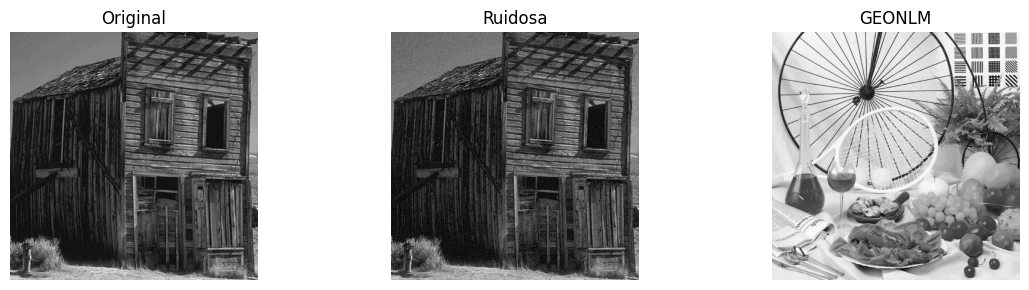

In [55]:

img_noisse_gaussian_np = array_nln_filtereds[0]['img_noisse_gaussian_np']

nlm_h = array_nln_filtereds[0]['nlm_h']
file_name = array_nln_filtereds[0]['file_name']

dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


img = skimage.io.imread(f'{dir_images}/{file_name}')
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Parâmetros
f = 4
t = 7
nn = 10




print("\n--- Executando Pipeline 512x512 com mult = 1.40 ---")
mult = 1.40
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.45 ---")
mult = 1.45
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.5 ---")
mult = 1.50
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()


--- Executando Pipeline 512x512 com mult = 1.40 ---

Executando GEONLM com h = 121.80 (base 87 * 1.4)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.11, SSIM: 0.8768, Score: 60.89
PSNR: 34.112, SSIM: 0.8768, Score: 60.89

--- Executando Pipeline 512x512 com mult = 1.45 ---

Executando GEONLM com h = 126.15 (base 87 * 1.45)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.17, SSIM: 0.8807, Score: 61.12
PSNR: 34.172, SSIM: 0.8807, Score: 61.12

--- Executando Pipeline 512x512 com mult = 1.5 ---

Executando GEONLM com h = 130.50 (base 87 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.20, SSIM: 0.8837, Score: 61.28
PSNR: 34.196, SSIM: 0.8837, Score: 61.28


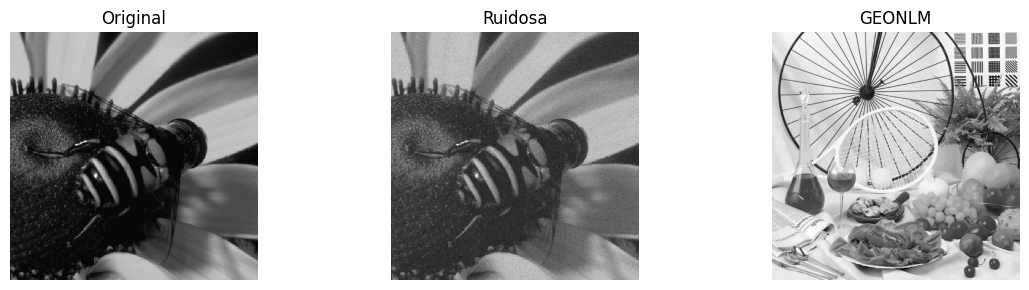

In [56]:

img_noisse_gaussian_np = array_nln_filtereds[1]['img_noisse_gaussian_np']

nlm_h = array_nln_filtereds[1]['nlm_h']
file_name = array_nln_filtereds[1]['file_name']

dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


img = skimage.io.imread(f'{dir_images}/{file_name}')
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Parâmetros
f = 4
t = 7
nn = 10




print("\n--- Executando Pipeline 512x512 com mult = 1.40 ---")
mult = 1.40
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.45 ---")
mult = 1.45
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.5 ---")
mult = 1.50
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()


--- Executando Pipeline 512x512 com mult = 1.40 ---

Executando GEONLM com h = 117.60 (base 84 * 1.4)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 32.77, SSIM: 0.8644, Score: 59.60
PSNR: 32.772, SSIM: 0.8644, Score: 59.60

--- Executando Pipeline 512x512 com mult = 1.45 ---

Executando GEONLM com h = 121.80 (base 84 * 1.45)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 32.84, SSIM: 0.8655, Score: 59.70
PSNR: 32.837, SSIM: 0.8655, Score: 59.70

--- Executando Pipeline 512x512 com mult = 1.5 ---

Executando GEONLM com h = 126.00 (base 84 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 32.87, SSIM: 0.8659, Score: 59.73
PSNR: 32.866, SSIM: 0.8659, Score: 59.73


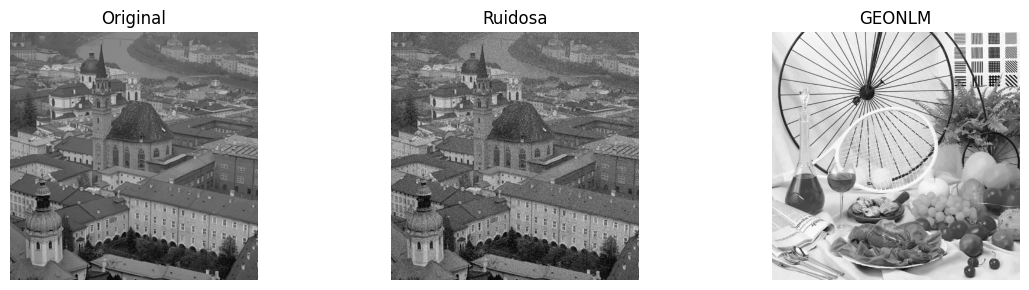

In [57]:

img_noisse_gaussian_np = array_nln_filtereds[2]['img_noisse_gaussian_np']

nlm_h = array_nln_filtereds[2]['nlm_h']
file_name = array_nln_filtereds[2]['file_name']

dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


img = skimage.io.imread(f'{dir_images}/{file_name}')
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Parâmetros
f = 4
t = 7
nn = 10




print("\n--- Executando Pipeline 512x512 com mult = 1.40 ---")
mult = 1.40
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.45 ---")
mult = 1.45
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.5 ---")
mult = 1.50
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()


--- Executando Pipeline 512x512 com mult = 1.40 ---

Executando GEONLM com h = 114.80 (base 82 * 1.4)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 33.20, SSIM: 0.8724, Score: 60.22
PSNR: 33.198, SSIM: 0.8724, Score: 60.22

--- Executando Pipeline 512x512 com mult = 1.45 ---

Executando GEONLM com h = 118.90 (base 82 * 1.45)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 33.29, SSIM: 0.8760, Score: 60.44
PSNR: 33.287, SSIM: 0.8760, Score: 60.44

--- Executando Pipeline 512x512 com mult = 1.5 ---

Executando GEONLM com h = 123.00 (base 82 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 33.35, SSIM: 0.8787, Score: 60.61
PSNR: 33.349, SSIM: 0.8787, Score: 60.61


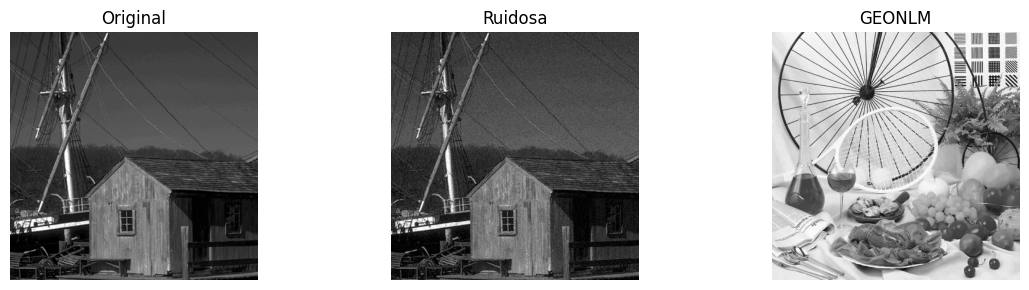

In [ ]:

img_noisse_gaussian_np = array_nln_filtereds[3]['img_noisse_gaussian_np']

nlm_h = array_nln_filtereds[3]['nlm_h']
file_name = array_nln_filtereds[3]['file_name']

dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


img = skimage.io.imread(f'{dir_images}/{file_name}')
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Parâmetros
f = 4
t = 7
nn = 10




print("\n--- Executando Pipeline 512x512 com mult = 1.40 ---")
mult = 1.55
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.45 ---")
mult = 1.60
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.5 ---")
mult = 1.50
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")

# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()


--- Executando Pipeline 512x512 com mult = 1.40 ---

Executando GEONLM com h = 127.10 (base 82 * 1.55)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 33.38, SSIM: 0.8807, Score: 60.73
PSNR: 33.383, SSIM: 0.8807, Score: 60.73

--- Executando Pipeline 512x512 com mult = 1.45 ---

Executando GEONLM com h = 131.20 (base 82 * 1.6)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 33.40, SSIM: 0.8821, Score: 60.80
PSNR: 33.396, SSIM: 0.8821, Score: 60.80


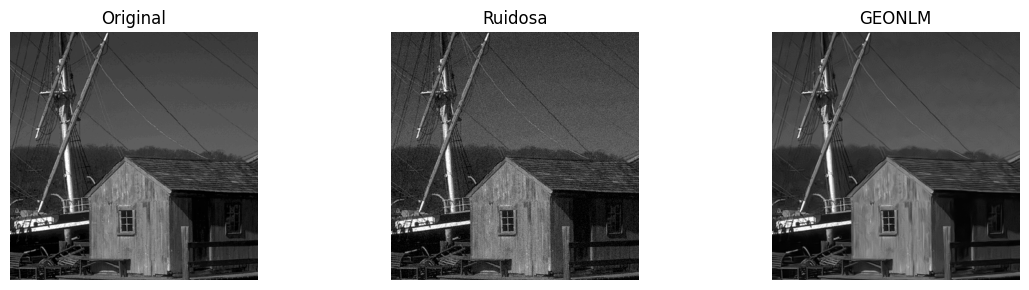

In [59]:
img_noisse_gaussian_np = array_nln_filtereds[3]['img_noisse_gaussian_np']

nlm_h = array_nln_filtereds[3]['nlm_h']
file_name = array_nln_filtereds[3]['file_name']

dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


img = skimage.io.imread(f'{dir_images}/{file_name}')
img = img[0, :, :] if len(img.shape) > 2 else img
if len(img.shape) > 2:
    img = skimage.color.rgb2gray(img)
    img = 255 * img

# Parâmetros
f = 4
t = 7
nn = 10




print("\n--- Executando Pipeline 512x512 com mult = 1.40 ---")
mult = 1.55
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")


print("\n--- Executando Pipeline 512x512 com mult = 1.45 ---")
mult = 1.60
# Executar o pipeline com a imagem ruidosa
img_filtered_gnlm3, h_gnlm3, psnr_gnlm3, ssim_gnlm3, score_gnlm3 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)

# Exibir o resultado

print(f"PSNR: {psnr_gnlm3:.3f}, SSIM: {ssim_gnlm3:.4f}, Score: {score_gnlm3:.2f}")




# ------------------------- VISUALIZAÇÃO -------------------------

import matplotlib.pyplot as plt

# Exibindo os resultados
plt.figure(figsize=(12, 3))
# plt.suptitle(f"Downscale 64x64 | h={h_val} | PSNR={psnr_val:.2f} | SSIM={ssim_val:.4f}")

# Exibindo as imagens de forma organizada
plt.subplot(1, 3, 1); plt.title("Original"); plt.imshow(img.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 2); plt.title("Ruidosa"); plt.imshow(img_noisse_gaussian_np.astype(np.uint8), cmap='gray'); plt.axis('off')
plt.subplot(1, 3, 3); plt.title("GEONLM"); plt.imshow(img_filtered_gnlm3.astype(np.uint8), cmap='gray'); plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
vetor2 = load_pickle("resultados.pkl")


array_gnlm_filtereds = []
for array in vetor2:

    img_noisse_gaussian_np =array['img_noisse_gaussian_np']
    img_filtered_nlm = array['img_filtered_nlm']
    nlm_h =array['nlm_h']
    file_name =array['file_name']

    dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


    img = skimage.io.imread(f'{dir_images}/{file_name}')
    img = img[0, :, :] if len(img.shape) > 2 else img
    if len(img.shape) > 2:
        img = skimage.color.rgb2gray(img)
        img = 255 * img

    # Parâmetros
    f = 4
    t = 7
    nn = 10

    ini = time.time()

    print("\n--- Executando Pipeline 512x512 com mult = 1.55 ---")
    mult = 1.55
    img_filtered_gnlm1, h_gnlm1, psnr_gnlm1, ssim_gnlm1, score_gnlm1 = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)   
    end = time.time()
    time_geonlm = end - ini

   

    dict = {
        'img_filtered_gnlm':img_filtered_gnlm,
        'h_gnlm':h_gnlm,
        'psnr_gnlm':psnr_gnlm,
        'ssim_gnlm':ssim_gnlm,
        'score_gnlm':score_gnlm,        
        'img_filtered_nlm': img_filtered_nlm,
        'img_noisse_gaussian_np':img_noisse_gaussian_np,
        'time_geonlm':time_geonlm,
        'nlm_h':nlm_h, 
        'nlm_psnr': nlm_psnr,
        'nlm_ssim':nlm_ssim,
        'nlm_score':nlm_score,
        'file_name':file_name,
    }
    array_gnlm_filtereds.append(dict)
save_pickle(array_gnlm_filtereds, "resultados_gnlm.pkl")

    


--- Executando Pipeline 512x512 com mult = 1.50 ---

Executando GEONLM com h = 132.00 (base 88 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520


→ PSNR: 31.53, SSIM: 0.9017, Score: 60.85
PSNR: 31.534, SSIM: 0.9017, Score: 60.85

--- Executando Pipeline 512x512 com mult = 1.55 ---

Executando GEONLM com h = 136.40 (base 88 * 1.55)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 31.50, SSIM: 0.9005, Score: 60.78
PSNR: 31.504, SSIM: 0.9005, Score: 60.78

--- Executando Pipeline 512x512 com mult = 1.60 ---

Executando GEONLM com h = 140.80 (base 88 * 1.6)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 31.45, SSIM: 0.8988, Score: 60.66
PSNR: 31.448, SSIM: 0.8988, Score: 60.66

--- Executando Pipeline 512x512 com mult = 1.50 ---

Executando GEONLM com h = 130.50 (base 87 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.20, SSIM: 0.8837, Score: 61.28
PSNR: 34.196, SSIM: 0.8837, Score: 61.28

--- Executando Pipeline 512x512 com mult = 1.55 ---

Executando GEONLM com h = 134.85 (base 87 * 1.55)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 34.19, SSIM: 0.8859, Score: 61.39
PSNR: 34.194, SSIM: 0.8859, Score: 61.39

--- Executando

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


→ PSNR: 32.84, SSIM: 0.8649, Score: 59.67
PSNR: 32.842, SSIM: 0.8649, Score: 59.67

--- Executando Pipeline 512x512 com mult = 1.50 ---

Executando GEONLM com h = 123.00 (base 82 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 33.35, SSIM: 0.8787, Score: 60.61
PSNR: 33.349, SSIM: 0.8787, Score: 60.61

--- Executando Pipeline 512x512 com mult = 1.55 ---

Executando GEONLM com h = 127.10 (base 82 * 1.55)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 33.38, SSIM: 0.8807, Score: 60.73
PSNR: 33.383, SSIM: 0.8807, Score: 60.73

--- Executando Pipeline 512x512 com mult = 1.60 ---

Executando GEONLM com h = 131.20 (base 82 * 1.6)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 33.40, SSIM: 0.8821, Score: 60.80
PSNR: 33.396, SSIM: 0.8821, Score: 60.80

--- Executando Pipeline 512x512 com mult = 1.50 ---

Executando GEONLM com h = 120.00 (base 80 * 1.5)
img_n.shape: (528, 528)
M: 520, N: 520
→ PSNR: 30.84, SSIM: 0.8175, Score: 56.30
PSNR: 30.843, SSIM: 0.8175, Score: 56.30

--- Executando 

In [ ]:
vetor2 = load_pickle("resultados.pkl")


array_gnlm_filtereds = []
for array in vetor2:

    img_noisse_gaussian_np =array['img_noisse_gaussian_np']
    img_filtered_nlm = array['img_filtered_nlm']
    nlm_h =array['nlm_h']
    file_name =array['file_name']
    nlm_psnr =array['nlm_psnr']
    nlm_ssim =array['nlm_ssim']
    nlm_score =array['nlm_score']   

    dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


    img = skimage.io.imread(f'{dir_images}/{file_name}')
    img = img[0, :, :] if len(img.shape) > 2 else img
    if len(img.shape) > 2:
        img = skimage.color.rgb2gray(img)
        img = 255 * img

    # Parâmetros
    f = 4
    t = 7
    nn = 10

    ini = time.time()

    print("\n--- Executando Pipeline 512x512 com mult = 1.55 ---")
    mult = 1.55
    img_filtered_gnlm, h_gnlm, psnr_gnlm, ssim_gnlm, score_gnlm = run_geonlm_pipeline(img, nlm_h, img_noisse_gaussian_np, f, t, mult, nn)   
    end = time.time()
    time_geonlm = end - ini

   

    dict = {
        'img_filtered_gnlm':img_filtered_gnlm,
        'h_gnlm':h_gnlm,
        'psnr_gnlm':psnr_gnlm,
        'ssim_gnlm':ssim_gnlm,
        'score_gnlm':score_gnlm,        
        'img_filtered_nlm': img_filtered_nlm,
        'img_noisse_gaussian_np':img_noisse_gaussian_np,
        'time_geonlm':time_geonlm,
        'nlm_h':nlm_h, 
        'nlm_psnr': nlm_psnr,
        'nlm_ssim':nlm_ssim,
        'nlm_score':nlm_score,
        'file_name':file_name,
    }
    array_gnlm_filtereds.append(dict)
save_pickle(array_gnlm_filtereds, "resultados_gnlm.pkl")

In [16]:
vetor_gnlm = load_pickle("resultados_gnlm.pkl")

In [21]:
vetor2 = load_pickle("resultados.pkl")
from bm3d import bm3d, BM3DProfile
from skimage.restoration import estimate_sigma
from skimage.color import rgb2gray

array_bm3d_filtereds = []
for array in vetor2:

    img_noisse_gaussian_np =array['img_noisse_gaussian_np']
    img_filtered_nlm = array['img_filtered_nlm']
    nlm_h =array['nlm_h']
    file_name =array['file_name']
    nlm_psnr =array['nlm_psnr']
    nlm_ssim =array['nlm_ssim']
    nlm_score =array['nlm_score']   

    dir_images = ("/workspace/ProjetoDoutorado/wvc/images")


    img = skimage.io.imread(f'{dir_images}/{file_name}')
    img = img[0, :, :] if len(img.shape) > 2 else img
    if len(img.shape) > 2:
        img = skimage.color.rgb2gray(img)
        img = 255 * img
    # Remove frames extras, se existirem (e.g. GIF com shape (1, H, W) ou (N, H, W, 3))
    if img.ndim == 4:
        img = img[0]
    elif img.ndim == 3 and img.shape[2] != 3:
        img = np.squeeze(img)

    # Converte para escala de cinza, se necessário
    if img.ndim == 3 and img.shape[2] == 3:
        img_gray = rgb2gray(img)  # retorna float64 em [0, 1]
    else:
        img_gray = img.astype(np.float32) / 255.0  # já está em cinza
     # Agora está garantidamente em escala de cinza float [0,1]
    img_gray = np.clip(img_gray * 255, 0, 255).astype(np.uint8)
    
     # 1. Normaliza a imagem ruidosa para intervalo [0, 1]
    ruidosa_normalizada = img_noisse_gaussian_np.astype(np.float32) / 255.0

    sigma_est = estimate_sigma(ruidosa_normalizada, channel_axis=None)

    # 3. Define o perfil padrão do BM3D
    perfil_bm3d = BM3DProfile()

    # 4. Aplica o BM3D com os argumentos definidos
    denoised = bm3d(
        ruidosa_normalizada,
        sigma_psd=sigma_est,
        profile=perfil_bm3d
    )
    denoised_sq = np.squeeze(denoised)

    
    psnr = peak_signal_noise_ratio(img_gray, (denoised * 255).astype(np.uint8))
    ssim = structural_similarity(img_gray, (denoised * 255).astype(np.uint8))
    score = 0.5 * psnr + 0.5 * (ssim * 100)

    print(f"PSNR: {psnr:.2f} dB")
    print(f"SSIM: {ssim:.4f}")

    dict = {
            'ssim': ssim,
            'psnr':psnr,        
            'image': file_name,
            'score':score,
        }
    array_bm3d_filtereds.append(dict)
save_pickle(array_bm3d_filtereds, "resultados_bm3d.pkl")

PSNR: 31.71 dB
SSIM: 0.9067
PSNR: 35.38 dB
SSIM: 0.9202
PSNR: 33.60 dB
SSIM: 0.8858
PSNR: 32.58 dB
SSIM: 0.9062
PSNR: 28.83 dB
SSIM: 0.8066
PSNR: 30.67 dB
SSIM: 0.8748
PSNR: 35.18 dB
SSIM: 0.8895
PSNR: 35.77 dB
SSIM: 0.9164
PSNR: 30.05 dB
SSIM: 0.8753
PSNR: 35.02 dB
SSIM: 0.9341
PSNR: 34.08 dB
SSIM: 0.9085
PSNR: 32.16 dB
SSIM: 0.8723
PSNR: 32.01 dB
SSIM: 0.9064
PSNR: 33.61 dB
SSIM: 0.9093
PSNR: 35.86 dB
SSIM: 0.9364
PSNR: 34.09 dB
SSIM: 0.8978
PSNR: 33.88 dB
SSIM: 0.8806
PSNR: 27.80 dB
SSIM: 0.8811
PSNR: 31.11 dB
SSIM: 0.8150
PSNR: 30.71 dB
SSIM: 0.9208
PSNR: 34.09 dB
SSIM: 0.9440
PSNR: 31.13 dB
SSIM: 0.9078
PSNR: 33.54 dB
SSIM: 0.8891
PSNR: 29.58 dB
SSIM: 0.8352
PSNR: 25.63 dB
SSIM: 0.8466
PSNR: 29.67 dB
SSIM: 0.8847
PSNR: 19.85 dB
SSIM: 0.7741
PSNR: 31.64 dB
SSIM: 0.8586
PSNR: 30.95 dB
SSIM: 0.8806
PSNR: 31.41 dB
SSIM: 0.9001
PSNR: 26.18 dB
SSIM: 0.7578
PSNR: 31.28 dB
SSIM: 0.8609
PSNR: 34.23 dB
SSIM: 0.8842
PSNR: 34.37 dB
SSIM: 0.9407
PSNR: 33.14 dB
SSIM: 0.8840
PSNR: 27.34 dB
SSIM:

In [22]:
array_bm3d_filtereds

[{'ssim': np.float64(0.9066909364029847),
  'psnr': np.float64(31.71406440584256),
  'image': '36.gif',
  'score': np.float64(61.19157902307052)},
 {'ssim': np.float64(0.9201542065312889),
  'psnr': np.float64(35.382823510889246),
  'image': '39.gif',
  'score': np.float64(63.69912208200907)},
 {'ssim': np.float64(0.8857828794990716),
  'psnr': np.float64(33.60087101047691),
  'image': '4.gif',
  'score': np.float64(61.089579480192036)},
 {'ssim': np.float64(0.9062007760857367),
  'psnr': np.float64(32.57820116841103),
  'image': '3.gif',
  'score': np.float64(61.59913938849235)},
 {'ssim': np.float64(0.8066351929812104),
  'psnr': np.float64(28.82808681580615),
  'image': '32.gif',
  'score': np.float64(54.745803056963595)},
 {'ssim': np.float64(0.874751924124374),
  'psnr': np.float64(30.67258919706006),
  'image': '7.gif',
  'score': np.float64(59.07389080474873)},
 {'ssim': np.float64(0.8895106116442547),
  'psnr': np.float64(35.183529925409466),
  'image': '40.gif',
  'score': np.